In [6]:
# test frequency spreading
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.colors
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt

from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf

%run -i wave_stats.py

In [43]:
stime = datetime.strptime('2022-09-26', '%Y-%m-%d')
etime = datetime.strptime('2022-10-01', '%Y-%m-%d')
buoys = "42097","42099","42098"
buoy = buoys[1]
url ='https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/' + str(buoy) + '/' + str(buoy) + 'w9999' + '.nc'
print(url)
# use wavespectra routine for reading & generating 2dspec
dso = read_ndbc(url, dd=10.0, chunks={}).sel(time=slice(stime, etime)).load()
dso

https://dods.ndbc.noaa.gov/thredds/dodsC/data/swden/42099/42099w9999.nc


<xarray.Dataset>
Dimensions:  (time: 121, freq: 64, lat: 1, lon: 1, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 2022-09-26 2022-09-26T01:00:00 ... 2022-10-01
  * freq     (freq) float32 0.025 0.03 0.035 0.04 0.045 ... 0.55 0.56 0.57 0.58
  * lat      (lat) float32 27.34
  * lon      (lon) float32 -84.28
  * dir      (dir) float64 0.0 10.0 20.0 30.0 40.0 ... 320.0 330.0 340.0 350.0
Data variables:
    efth     (time, lat, lon, freq, dir) float64 0.0 0.0 ... 0.0002201 0.0002314

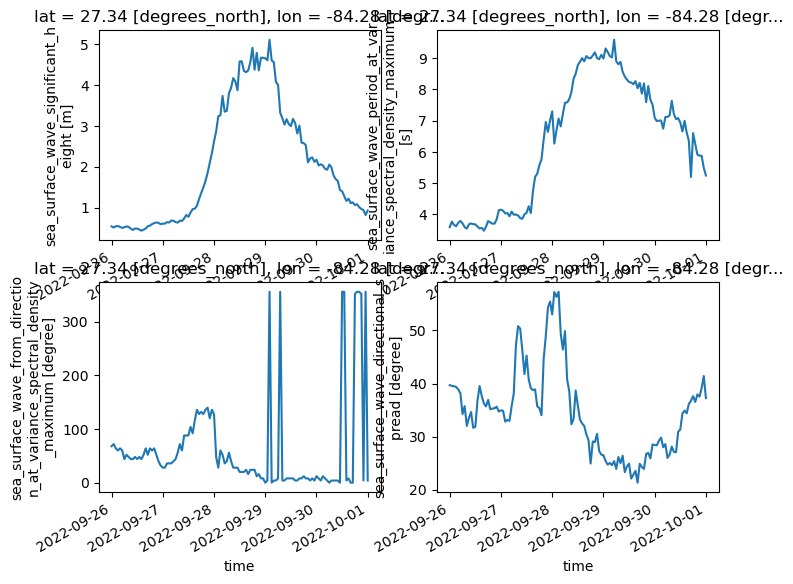

In [44]:
stats = dso.isel(lat=0, lon=0).spec.stats(["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"])
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
stats.hs.plot.line(ax=ax1, x="time");
stats.tp.plot.line(ax=ax2, x="time");
stats.dpm.plot.line(ax=ax3, x="time");
stats.dspr.plot.line(ax=ax4, x="time");
plt.draw()

hs:  1.952512258076253
Tp:  6.7439466


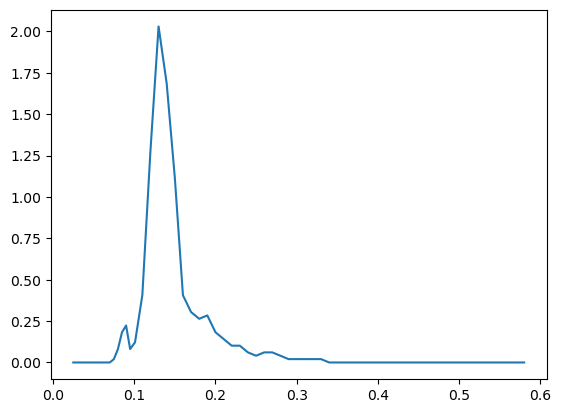

In [61]:
print('hs: ', dso.isel(lat=0, lon=0, time=100).spec.hs().values )
print('Tp: ', dso.isel(lat=0, lon=0, time=100).spec.tp().values )
spec1d = np.nansum( dso.isel(lat=0, lon=0, time=55)['efth'].values, 1 )
plt.plot(f,spec1d)

In [88]:
def calc_sigmaf_Qp_1d( spec1d, f, fmin=0.056, fmax=0.28 ):
    # frequency spread () LeMerle et al., 2021 eqns. 3 and 4, based on Blackman & Tukey (1959)
    s1d = np.nan_to_num( spec1d ) 
    idx = np.squeeze( np.argwhere( (f >= fmin) & (f <= fmax) ) )
    sigma_f = (np.trapz( s1d[idx], x=f[idx] )**2 /  np.trapz( s1d[idx]**2, x=f[idx] ) )
    Qp = (np.trapz( f[idx] * s1d[idx]**2, x=f[idx]) /  np.trapz( s1d[idx], x=f[idx] )**2 )
    return sigma_f, Qp


In [93]:
nt = len(dso['time'].values)
t = dso['time'].values
sf = np.ones(nt)*np.nan
qp = np.ones(nt)*np.nan
for i in np.arange( len(dso['time'].values) ):
    spec1d = np.nansum( dso.isel(lat=0, lon=0, time=i)['efth'].values, 1 )
    sf[i], qp[i] = calc_sigmaf_Qp_1d( spec1d, f )

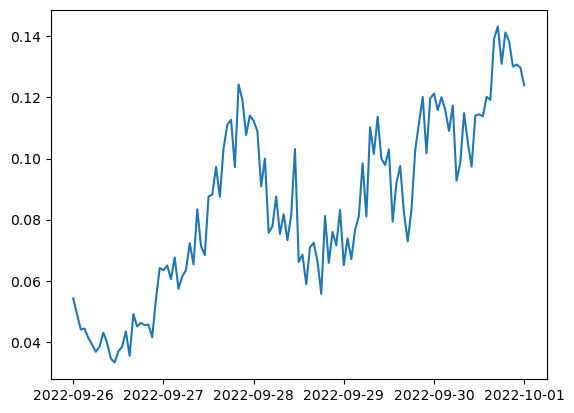

In [96]:
plt.plot(t,sf)

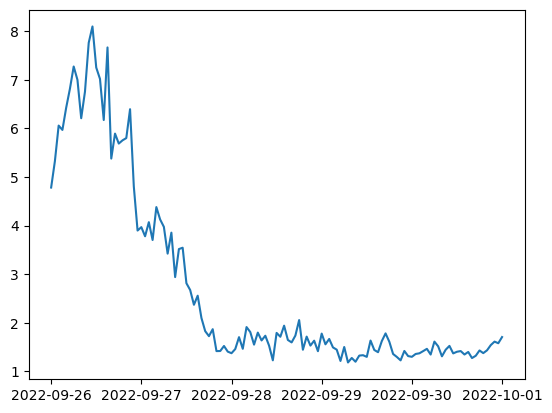

In [97]:
plt.plot(t,qp)